# Erkennung lokaler Maxima
Zur Erkennung lokaler Maxima, also Pixel, die von Pixeln mit geringerer Intensität umgeben sind, können wir einige Funktionen in [scikit-image](https://scikit-image.org) und [clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) verwenden.

Siehe auch
* [Lokale Maxima finden (scikit-image Tutorial)](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html)

In [1]:
from skimage.feature import peak_local_max
import pyclesperanto_prototype as cle
from skimage.io import imread, imshow
from skimage.filters import gaussian 
import matplotlib.pyplot as plt

Wir beginnen mit dem Laden eines Bildes und schneiden einen Bereich für Demonstrationszwecke aus. Wir haben den Bildsatz [BBBC007v1](https://bbbc.broadinstitute.org/BBBC007) Version 1 verwendet (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), der von der Broad Bioimage Benchmark Collection verfügbar ist [Ljosa et al., Nature Methods, 2012].

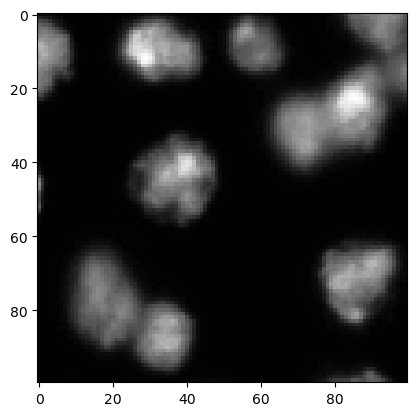

In [2]:
image = imread("../../data/BBBC007_batch/A9 p7d.tif")[-100:, 0:100]

cle.imshow(image)

## Vorverarbeitung
Ein üblicher Vorverarbeitungsschritt vor der Erkennung von Maxima ist das Weichzeichnen des Bildes. Dies macht Sinn, um zu vermeiden, dass Maxima erkannt werden, die nur Intensitätsschwankungen aufgrund von Rauschen sind.

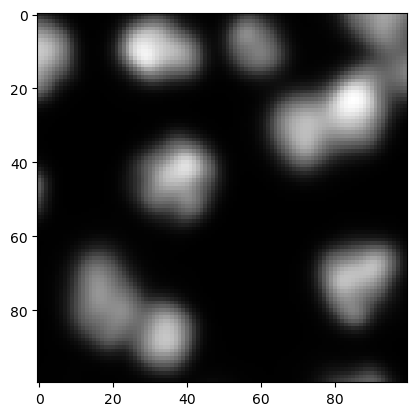

In [3]:
preprocessed = gaussian(image, sigma=2, preserve_range=True)

cle.imshow(preprocessed)

## peak_local_max
Die [`peak_local_max` Funktion](https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=peak_local_max#skimage.feature.peak_local_max) ermöglicht es, Maxima zu erkennen, die eine höhere Intensität als umgebende Pixel und andere Maxima gemäß einem definierten Schwellenwert haben.

In [4]:
coordinates = peak_local_max(preprocessed, threshold_abs=5)
coordinates

array([[23, 85],
       [11, 29],
       [41, 40],
       [88, 34],
       [72, 83],
       [69, 89],
       [31, 72],
       [75, 16],
       [80, 22],
       [ 6, 56]], dtype=int64)

Diese Koordinaten können mit der Plot-Funktion von matplotlib visualisiert werden.

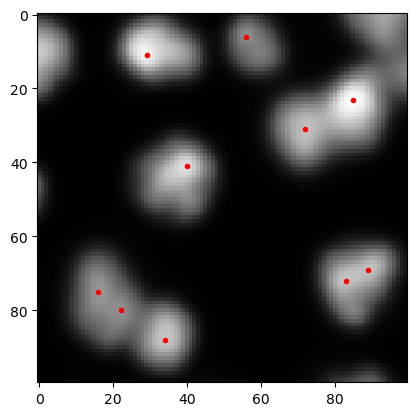

In [5]:
cle.imshow(preprocessed, continue_drawing=True)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

Wenn zu viele Maxima erkannt werden, kann man die Ergebnisse durch Änderung des `sigma`-Parameters der Gaußschen Unschärfe oben oder durch Änderung des Schwellenwerts, der an die Funktion `peak_local_max` übergeben wird, modifizieren.

## detect_maxima_box

Die Funktion `peak_local_max` neigt dazu, lange zu dauern, z.B. bei der Verarbeitung großer 3D-Bilddaten. Daher soll eine Alternative vorgestellt werden: clesperanto's `detect_maxima_box` ist ein Bildfilter, der Pixel auf den Wert `1` setzt, falls umgebende Pixel eine geringere Intensität haben. Er ist typischerweise auch bei großen 3D-Bilddaten schnell.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
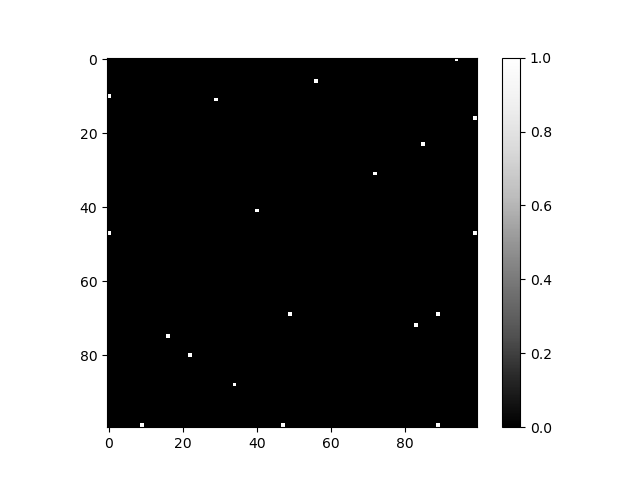
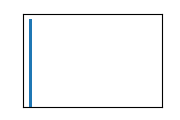

In [6]:
local_maxima_image = cle.detect_maxima_box(preprocessed)
local_maxima_image

Offensichtlich ergibt dies ein Binärbild. Dieses Binärbild kann in ein Labelbild umgewandelt werden, indem einzelne Spots mit verschiedenen Nummern gekennzeichnet werden. Aus diesem Labelbild können wir Maxima entfernen, die an Bildrändern erkannt wurden, was in diesem Fall nützlich sein könnte.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
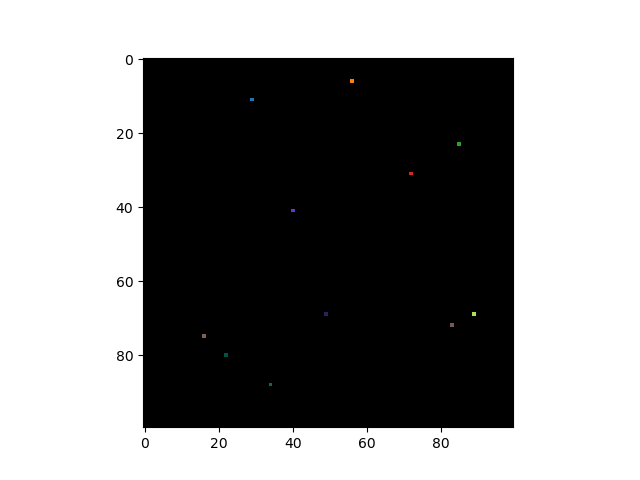

In [7]:
all_labeled_spots = cle.label_spots(local_maxima_image)

labeled_spots = cle.exclude_labels_on_edges(all_labeled_spots)
labeled_spots

Um diese Spots auf dem Originalbild zu visualisieren, könnte es sinnvoll sein, die Größe der Spots zu erhöhen - nur für Visualisierungszwecke.

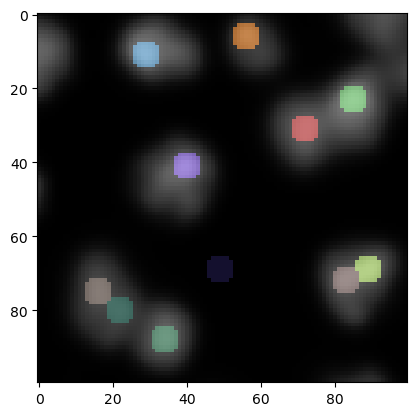

In [8]:
label_visualization = cle.dilate_labels(labeled_spots, radius=3)

cle.imshow(preprocessed, continue_drawing=True)
cle.imshow(label_visualization, labels=True, alpha=0.5)

In der unteren Mitte dieses Bildes sehen wir jetzt ein lokales Maximum, das im Hintergrund erkannt wurde. Wir können diese Maxima in Bereichen niedrigerer Intensität durch Schwellenwertbildung entfernen.

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
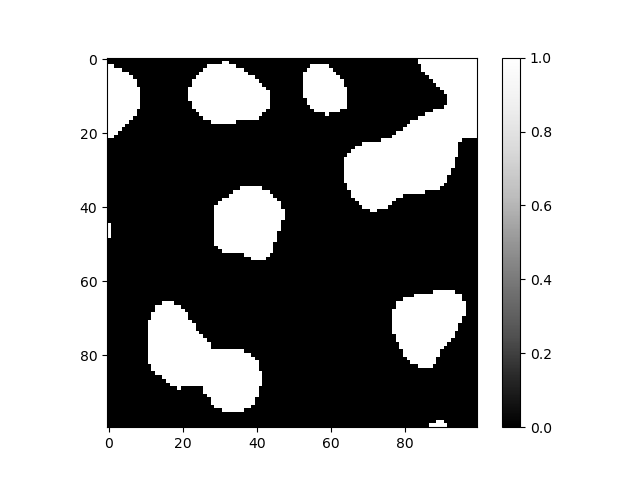
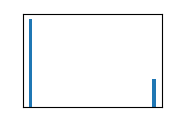

In [9]:
binary_image = cle.threshold_otsu(preprocessed)
binary_image

Wir können jetzt Labels aus dem Spots-Bild ausschließen, bei denen die Intensität im Binärbild nicht im Bereich `[0..1]` liegt.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
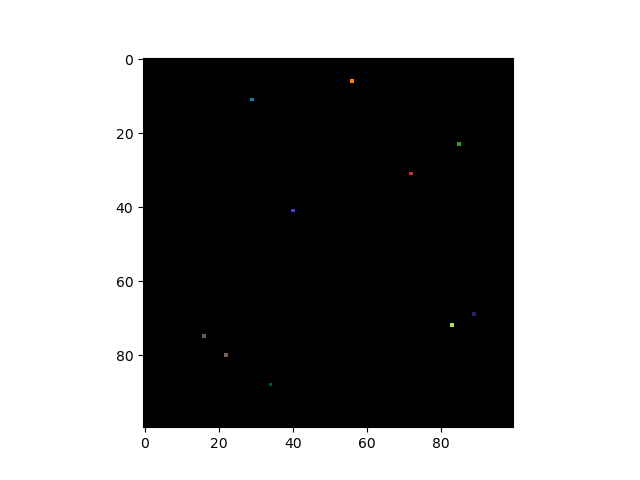

In [10]:
final_spots = cle.exclude_labels_with_map_values_out_of_range(
    binary_image,
    labeled_spots,
    minimum_value_range=1,
    maximum_value_range=1
)
final_spots

Wir können dann die Spots erneut mit der oben vorgestellten Strategie visualisieren, diesmal jedoch auf dem Originalbild.

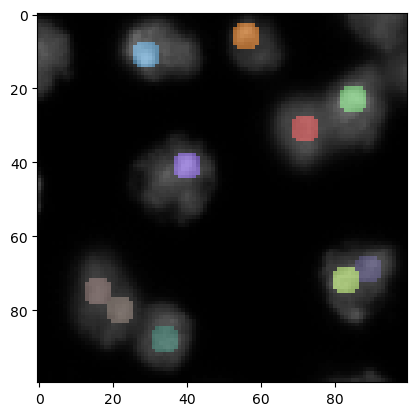

In [11]:
label_visualization2 = cle.dilate_labels(final_spots, radius=3)

cle.imshow(image, continue_drawing=True)
cle.imshow(label_visualization2, labels=True, alpha=0.5)